# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `6`
* Students: `<the name of all students in the team>`
* Dataset: `Flight Routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [45]:
data=pd.read_csv('routes.dat.txt', sep=',', encoding='utf-8', engine='python')
data.columns=['Airlines','AirlineID','SourceAirport','SourceAirportID','DestinationAirport','DestinationAirportID','Codeshare','Stops','Equipment']
data.head()

,Airlines,AirlineID,SourceAirport,SourceAirportID,DestinationAirport,DestinationAirportID,Codeshare,Stops,Equipment
0,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
2,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
3,2B,410,CEK,2968,OVB,4078,NaN,0,CR2
4,2B,410,DME,4029,KZN,2990,NaN,0,CR2


### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

#### Creating a DataFrame with airports and airportsID (nodes)

In [46]:
source_airports = data[['SourceAirport','SourceAirportID']]
source_airports.columns = ['Airport','AirportID']
destination_airports = data[['DestinationAirport','DestinationAirportID']]
destination_airports.columns = ['Airport','AirportID']
destination_airports.head()

,Airport,AirportID
0,KZN,2990
1,MRV,2962
2,KZN,2990
3,OVB,4078
4,KZN,2990


In [47]:
airports = pd.concat([source_airports,destination_airports]);
airports = airports.drop_duplicates() #Keep only unique lines
airports = airports.reset_index() #Reinitialing index
airports = airports.drop('index',1) #Delete older inder
airports.head()

,Airport,AirportID
0,ASF,2966
1,CEK,2968
2,DME,4029
3,EGO,6156
4,GYD,2922


In [48]:
nodes = airports
nodes = nodes.reset_index() #Reinitialing index
# Create a conversion table from uid to node index.
aid2idx = nodes[['index', 'AirportID']]
aid2idx.head()

,index,AirportID
0,0,2966
1,1,2968
2,2,4029
3,3,6156
4,4,2922


In [49]:
n_nodes = len(nodes) # the number of nodes in the network
print(n_nodes)

3425


#### Creating edge DataFrame

In [50]:
flights=data[['SourceAirportID','DestinationAirportID']]
flights.head(3)

,SourceAirportID,DestinationAirportID
0,2966,2990
1,2966,2962
2,2968,2990


In [51]:
edges = pd.merge(flights, aid2idx, left_on='SourceAirportID', right_on='AirportID')
edges.rename(columns={'index':'SourceIndex'}, inplace=True)
edges = edges.drop('SourceAirportID',1)
edges.head(3)

,DestinationAirportID,SourceIndex,AirportID
0,2990,0,2966
1,2962,0,2966
2,4029,0,2966


In [52]:
edges = pd.merge(edges, aid2idx, left_on='DestinationAirportID', right_on='AirportID')
edges.rename(columns={'index':'DestinationIndex'}, inplace=True)
edges = edges.drop('DestinationAirportID',1)
edges.head(3)

,SourceIndex,AirportID_x,DestinationIndex,AirportID_y
0,0,2966,6,2990
1,1,2968,6,2990
2,2,4029,6,2990


In [53]:
edges = edges.drop('AirportID_x',1)
edges = edges.drop('AirportID_y',1)
edges.head(3)

,SourceIndex,DestinationIndex
0,0,6
1,1,6
2,2,6


#### Creating the adjency matrix

In [54]:
adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
for idx, row in edges.iterrows():
    d, s = int(row.SourceIndex), int(row.DestinationIndex)
    adjacency[s, d] = adjacency[s, d] + 1
    adjacency[d, s] = adjacency[d, s] + 1

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

Text(0.5, 1.05, 'Adjacency matrix')

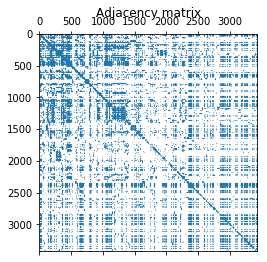

In [66]:
plt.spy(adjacency, markersize=0.1)
plt.title('Adjacency matrix')

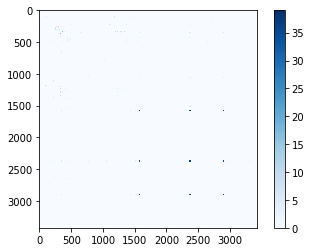

In [67]:
plt.imshow(adjacency, cmap=plt.cm.Blues);
plt.colorbar();
plt.show()

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

$L_{max}=\frac{N(N-1)}{2}$ 

In [81]:
Lmax = n_nodes*(n_nodes-1)/2
Lmax

5863600.0

$L=\frac{1}{2}\sum_{i=1}^{N}k_i$

In [82]:
L = np.sum(adjacency)/2
L

256851.0

In [83]:
L/Lmax

0.04380431816631421

The network is very sparse.

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Your answer here.**

In [56]:
#It is an directed graph

# Your code here.

### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [57]:
# Your code here.

### Question 4

Are the edges of your graph weighted?

Yes they are

### Question 5

What is the degree distibution of your network? 

In [58]:
degree =  # Your code here. It should be a numpy array.

assert len(degree) == n_nodes

SyntaxError: invalid syntax (<ipython-input-58-a52eedad56d1>, line 1)

Execute the cell below to see the histogram of the degree distribution.

In [ ]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

What is the average degree?

In [ ]:
# Your code here.

### Question 6

Comment on the degree distribution of your network.

**Your answer here.**

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [ ]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """
    
    # Your code here.
    
    return connected

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [ ]:
# Your code here.

### Question 8

Write a function that extracts the connected components of a graph.

In [ ]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Your code here.
    
    return components

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [ ]:
# Your code here.

### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [ ]:
def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    
    # Your code here.
    
    return shortest_path_lengths

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [ ]:
# Your code here.

### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [ ]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    
    # Your code here.
    
    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [ ]:
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [ ]:
# Your code here.

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [ ]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    
    # Your code here.
    
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [ ]:
# Your code here.